## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

import pickle

from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.filterwarnings('ignore')

## Import Dataset

In [2]:
df_fake = pd.read_csv('Fake_news.csv')
df_true = pd.read_csv('True_news.csv')

## Dataset Processing

In [3]:
df_fake['subject'].unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

In [4]:
df_true['subject'].unique()

array(['politicsNews', 'worldnews'], dtype=object)

In [5]:
df_fake = df_fake[df_fake['subject'] == 'politics']
df_true = df_true[df_true['subject'] == 'politicsNews']
df_fake.drop(columns = ['subject', 'date'], inplace = True)
df_true.drop(columns = ['subject', 'date'], inplace = True)
df_true.head()

,title,text
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...


In [6]:
df_true['target'] = 1
df_fake['target'] = 0
df = pd.concat([df_true, df_fake], axis = 0).reset_index(drop = True)
df.head(2)

,title,text,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1


## Data Cleaning

In [7]:
def text(sentence):
    sentence = sentence.lower()
    sentence = re.sub('&#039', ' ', sentence)
    sentence = re.sub(r'\W', ' ', sentence)
    sentence = re.sub(r'[^\x00-\x7F]+',' ', sentence)
    sentence = re.sub(r'\.{2,}', ' ', sentence)
    sentence = re.sub("(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2, 6})([\/\w \.-]*)*\/?", ' ', sentence)
    sentence = re.sub("@[a-zA-Z0-9_]+", ' ', sentence)
    words = word_tokenize(sentence)
    
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')
    
    ps = PorterStemmer()
#     ss = SnowballStemmer('english')
    
    words = [ps.stem(word) for word in words if not word in set(all_stopwords)]
    sentense = " ".join(words)
    
    return sentense

In [8]:
df['clean_title'] = df['title'].apply(text)
df['clean_text'] = df['text'].apply(text)
df.head(2)

,title,text,target,clean_title,clean_text
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1,u budget fight loom republican flip fiscal script,washington reuter head conserv republican fact...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1,u militari accept transgend recruit monday pen...,washington reuter transgend peopl allow first ...


In [9]:
df['combine'] = df['clean_title'] + ' ' + df['clean_text']
df.head(2)

,title,text,target,clean_title,clean_text,combine
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1,u budget fight loom republican flip fiscal script,washington reuter head conserv republican fact...,u budget fight loom republican flip fiscal scr...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1,u militari accept transgend recruit monday pen...,washington reuter transgend peopl allow first ...,u militari accept transgend recruit monday pen...


## EDA

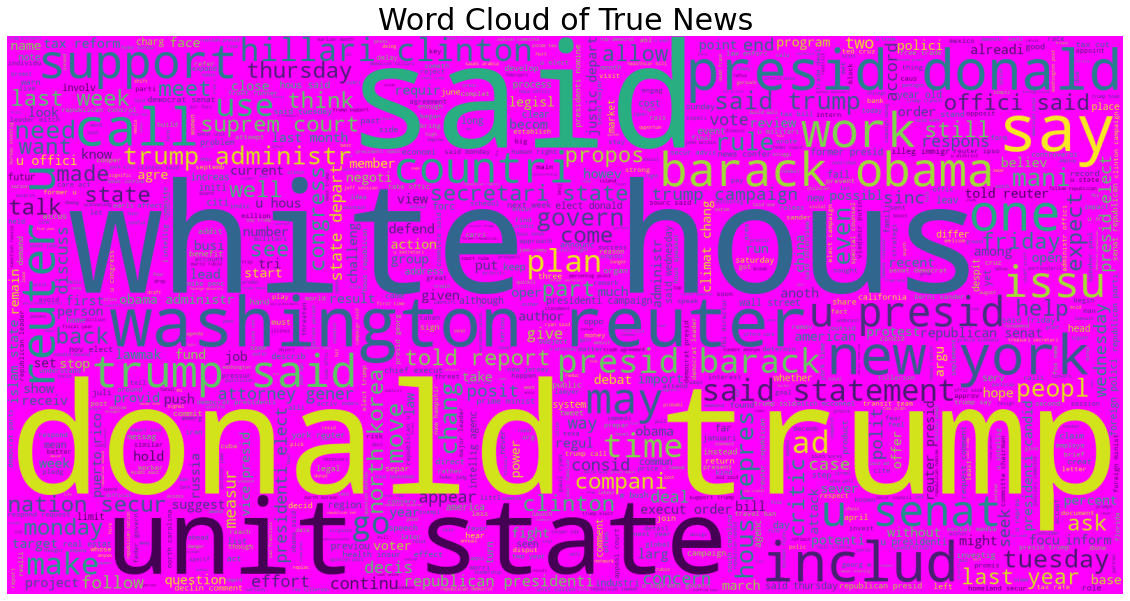

In [10]:
# True News
inp = df['combine'][df['target'] == 1]
inp = " ".join([i for i in inp])

plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 1000, width = 1600, height = 800, stopwords = STOPWORDS, background_color = 'magenta').generate(inp)
plt.title('Word Cloud of True News', fontsize = 30)
plt.axis('off')
plt.imshow(wc)
plt.show()

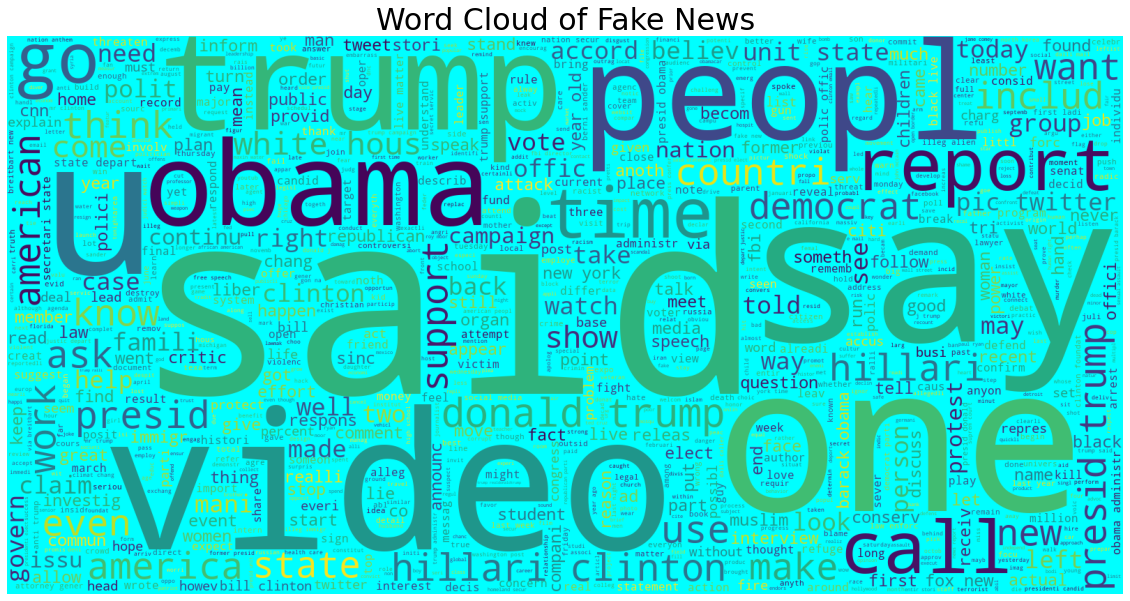

In [11]:
# Fake News
inp = df['combine'][df['target'] == 0]
inp = " ".join([i for i in inp])

plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 1000, width = 1600, height = 800, stopwords = STOPWORDS, background_color = 'cyan').generate(inp)
plt.title('Word Cloud of Fake News', fontsize = 30)
plt.axis('off')
plt.imshow(wc)
plt.show()

In [12]:
X = df.drop(columns = ['target'])
y = df['target']

## Splitting the Data

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X['combine'], y, random_state = 21, test_size = 0.2)

## Vectorization

In [14]:
count_vec = CountVectorizer(ngram_range = (1, 3)).fit(X_train)

X_count_train = count_vec.transform(X_train)
X_count_test = count_vec.transform(X_test)

## Model

In [15]:
C1 = [0.1, 0.25, 0.5, 0.75]
best_acc = 99
for c in C1:
    lr = LogisticRegression(C = c)
    lr.fit(X_count_train, y_train)
    predict_lr = lr.predict(X_count_test)
    acc_lr = accuracy_score(y_test, predict_lr)
    print(f'Accuracy of lr model is {round(acc_lr*100, 2)}')
    if best_acc < acc_lr*100:
        pickle.dump(lr, open('finalized_model.sav', 'wb'))
        best_acc = acc_lr

Accuracy of lr model is 99.12
Accuracy of lr model is 99.12
Accuracy of lr model is 99.09
Accuracy of lr model is 99.12


In [18]:
from sklearn.metrics import f1_score, precision_score, recall_score

In [19]:
lr = LogisticRegression(C = 0.1)
lr.fit(X_count_train, y_train)
predict_lr = lr.predict(X_count_test)
acc_lr = accuracy_score(y_test, predict_lr)
cm = confusion_matrix(y_test, predict_lr)
f1 = f1_score(y_test, predict_lr)
pr = precision_score(y_test, predict_lr)
re = recall_score(y_test, predict_lr)

print(f'Accuracy of lr model is {round(acc_lr*100, 2)}')
print(f'Confusion matrix of lr model is \n {cm}')
print(f'F1 Score of lr model is {round(f1, 4)}')
print(f'Precision Score of lr model is {pr}')
print(f'Recall Score of lr model is {re}')

Accuracy of lr model is 99.12
Confusion matrix of lr model is 
 [[1341   18]
 [  14 2250]]
F1 Score of lr model is 0.9929
Precision Score of lr model is 0.9920634920634921
Recall Score of lr model is 0.9938162544169611
